In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch

from importlib import reload
from copy import deepcopy
from typing import List

import utils.plots_cliffwalking as plots
from env.cliff_walking import WindyCliffWalking


# Resolvendo o ambiente Lunar Lander com Deep Q-Learning

O [Cliff Walking](https://gymnasium.farama.org/environments/box2d/lunar_lander/) é consideravelmente mais complexo que o Cliff Walking, mas nos permitirá utilizar mais o potencial da rede neural do Deep Q-Learning. Nesse ambiente, o objetivo é pousar uma nave espacial na Lua, tendo como ações possíveis o controle de três motores e um vetor de estados com informações sobre a posição, velocidade, rotação e se as pernas da nave estão em contato com o chão. 

<img src="media/lunar_lander.gif" width="200">

Abaixo seguem algumas informações importantes para a modelagem do ambiente como um Processo de Decisão de Markov (MDP):

### Espaço de ações

O espaço de ações é discreto e contém os inteiros do intervalo {0, 3}. As ações controlam a nave a partir de seus motores:
* 0: Não fazer nada
* 1: Ligar motor da esquerda
* 2: Ligar motor principal
* 3: Ligar motor da direita

### Espaço de estados

O vetor de estados possui oito elementos: posição (x, y) da nave, velocidade linear (x, y), ângulo, velocidade angular e dois valores booleanos que indicam se as pernas da nave estão ou não em contato com o chão. 

### Recompensas

O agente recebe uma recompensa a cada passo. A recompensa de cada passo:

- é aumentada/diminuída dependendo do quão perto/longe a nave está da plataforma de pouso.

- é aumentada/diminuída dependendo do quão devagar/rápido a nave está se movendo.

- é diminuída o quanto mais a nave estiver rotacionada.

- é aumentada em 10 pontos para cada perna em contato com o chão.

- é diminuída em 0.03 pontos a cada frame em que um motor lateral estiver ativo.

- é diminuída em 0.3 pontos a cada frame que o motor principal está ativo.

Além disso, o episódio recebe uma recompensa final de -100 ou +100 caso a nave colida ou pouse seguramente, respectivamente. 



## Explorando o espaço de estados

Por se tratarem de grandezas distintas, a faixa de valores para cada elemento do vetor de estados é diferente, o que pode levar a instabilidades no treinamento. Esse problema pode ser mitigado através da normalização do vetor de estados. No nosso caso, vamos fazer uma normalização minmax. 

In [8]:
lunar_lander = gym.make("LunarLander-v2")

low = lunar_lander.observation_space.low
high = lunar_lander.observation_space.high

print(f'features range: {high-low}')

# defining low and high as constants tensors
LOW = torch.tensor(low).float()
HIGH = torch.tensor(high).float()

def normalize_state(state) -> torch.Tensor:
    return torch.div((state - LOW),  (HIGH - LOW)).float()

features range: [ 3.         3.        10.        10.         6.2831855 10.
  1.         1.       ]


## Criando o modelo

No Deep Q-Learning, os Q-valores de cada ação associados a um estado são calculados através de uma rede neural. Ou seja, a rede neural recebe como entrada um vetor de estados e deve retornar o vetor de Q-valores onde cada elemento representa o Q-valor da ação i. Um Q-valor pode ser interpretado como "a recompensa acumulada total esperada por executar a ação A no estado S e depois seguir a mesma política até o final do episódio".

Por se tratar de um problema relativamente simples, o modelo para solucionar o CliffWalking pode ser uma rede MLP simples com uma única camada oculta. Além disso, note que a predição dos Q-valores é uma tarefa de regressão, portanto não há necessidade de softmax no final da rede. 

In [9]:
class Qnet(torch.nn.Module):
    def __init__(self, layer_sizes: List[int] = [64, 64]):
        super().__init__()

        n_actions = 4

        layers = []
        input_size = 8 # entrada: [x, y, v_x, v_y, theta, omega, left_leg, right_leg]
        for n_neurons in layer_sizes:
            layers.append(torch.nn.Linear(input_size, n_neurons))
            layers.append(torch.nn.ReLU())
            input_size = n_neurons
        layers.append(torch.nn.Linear(input_size, n_actions))
        self.model = torch.nn.Sequential(*layers)

    def initialize(self):
        for layer in self.model:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                layer.bias.data.fill_(0.01)

    def forward(self, x: int):
        x = normalize_state(x)
        x = self.model(x)
        return x

## Amostrando ações com a política $\epsilon$-greedy

No final do treinamento, espera-se que a melhor ação para cada estado seja aquela cujo Q-Valor é o maior. No entanto, para que o Q-Learning convirja adequadamente, é necessário que no início do treinamento o agente "explore" bem o ambiente. Isto é, que o agente visite um grande número de estados mesmo que não sejam necessariamente ótimos. Uma técnica amplamente utilizada para essa finalidade é a política $\epsilon$-greedy. Ela consiste em forçar o agente a escolher ações aleatoriamente com uma frequência que diminui conforme o treinamento avança.

In [10]:
def get_action(model, state, epsilon, random=True, n_actions=4):
    if torch.rand(1) < epsilon and random:
        return torch.randint(n_actions, (1,)).item()
    qvals = model(state)
    return torch.argmax(qvals).item()

## Treinamento da rede neural 

A cada passo do treinamento, o agente executará uma ação e utilizará a informação retornada pelo ambiente para calcular uma loss e atualizar seus pesos de forma a minimizá-la. A loss que será utilizada é o erro quadrático médio entre o Q-valor escolhido e o maior Q-valor do próximo estado calculado utilizando a rede com os pesos anteriores à ultima atualização:

$$L_i(\theta_i)=\mathbb{E}[(y_i - Q(s,a;\theta_i))^2]$$
$$y_i=\mathbb{E}[R(s')+\gamma\max_A Q(s',A;\theta_{i-1})]$$

Note que, portanto, serão necessárias duas redes neurais com a mesma arquitetura, mas uma terá os pesos defasados em uma iteração com relação à outra.

In [11]:
def update_q_net(model: torch.nn.Module, 
                 model_target: torch.nn.Module,
                 optimizer: torch.optim.Optimizer, 
                 state, action, reward, next_state, terminated, gamma):
    optimizer.zero_grad()
    prediction = model(state)[action]

    # se o estado é terminal, o valor é a recompensa
    with torch.no_grad():
        target = reward + gamma * torch.max(model_target(next_state)) if not terminated else torch.tensor(reward, dtype=torch.float32) 
    
    loss = torch.nn.functional.mse_loss(prediction, target)
    loss.backward()

    # atualizando os pesos da rede defasada
    model_target.load_state_dict(model.state_dict())

    # atualizando os pesos da rede
    optimizer.step()

    return model, model_target

## Loop de treinamento

No loop de treinamento, juntaremos todas as funções desenvolvidas até o momento. A ideia principal é definir um número máximo de episódios (estágio inicial até o estágio final) para que o agente colete experiências do ambiente e otimize sua tabela de QValores.

In [12]:
def train(env: gym.Env, 
          model,
          n_episodes=5000, # numero maximo de episodios
          epsilon=0.9, # probabilidade inicial de escolher uma ação aleatória
          epsilon_decay=0.999, # fator de decaimento da probabilidade de escolher uma ação aleatória
          learning_rate=0.0001, # taxa de aprendizado
          gamma=0.99, # fator de desconto
          verbose=False):
    
    model_target = deepcopy(model)

    model.initialize()
    model_target.initialize()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    total_rewards = []
    avg_rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        step = 0
        done = False

        if epsilon > 0.001:
            epsilon *= epsilon_decay
        
        while not done and step < 500: # 1000 steps max
            action = get_action(model, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            model, model_target = update_q_net(model, model_target, optimizer, state, action, reward, next_state, terminated, gamma)
            state = next_state
            total_reward += reward

            done = terminated or truncated
            step += 1
        
        total_rewards.append(total_reward)
        avg_reward = sum(total_rewards[-50:]) / len(total_rewards[-50:])
        if episode % 50:
            avg_rewards.append(avg_reward)
        if episode % 100 == 0 and verbose:
            clear_output(wait=True)
            debug_model.load_state_dict(model.state_dict())
            print(f"Episode {episode} - Average total reward: {avg_reward} - epsilon: {epsilon}")
            plt.plot(avg_rewards)
            plt.show()

    return model

## Treinando

Está tudo configurado, portanto agora podemos rodar o algoritmo!

In [13]:
lunar_lander = gym.make('LunarLander-v2')
q_net = Qnet(layer_sizes=[128, 128])
debug_model = deepcopy(q_net)
trained_q_net = train(lunar_lander, q_net, n_episodes=5000, learning_rate=1e-5, verbose=True)

TypeError: div(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

## Testando o agente

A função abaixo rodará um episódio com o agente já treinado.

In [ ]:
def test(env: gym.Env, 
          q_net,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_net, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    return torch.mean(total_reward)

#test(gym.make('CliffWalking-v0', render_mode="human"), trained_q_net)

## Análise de resultados

### Visualizando a política

A célula abaixo permitirá observar a ação mais provável de ser tomada em cada uma das posições do tabuleiro.

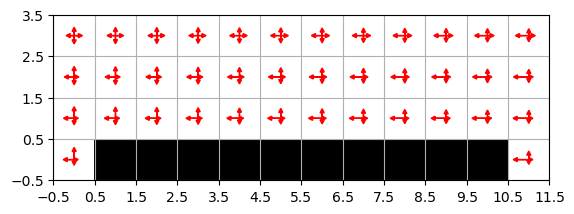

In [ ]:
reload(plots)
plots.plot_arrows_from_qnet(debug_model)

In [ ]:
for state in range(48):
    print(f'state {state}: {debug_model(state).detach().numpy()}')

state 0: [-99.32302 -99.32125 -99.32189 -99.39064]
state 1: [-99.37512  -99.38653  -99.397316 -99.32632 ]
state 2: [-99.42722 -99.45182 -99.47275 -99.262  ]
state 3: [-99.479324 -99.517105 -99.54818  -99.19767 ]
state 4: [-99.531425 -99.58239  -99.62361  -99.13336 ]
state 5: [-99.58353  -99.64768  -99.69904  -99.069046]
state 6: [-99.63563  -99.712975 -99.77447  -99.00472 ]
state 7: [-99.68773 -99.77827 -99.8499  -98.9404 ]
state 8: [-99.73983  -99.843544 -99.92533  -98.87608 ]
state 9: [ -99.79193   -99.90884  -100.00076   -98.811775]
state 10: [ -99.844025  -99.97412  -100.07619   -98.747444]
state 11: [ -99.896126 -100.03941  -100.15163   -98.68313 ]
state 12: [ -99.34171  -101.59196   -99.90222   -99.441574]
state 13: [ -99.39381 -101.65725  -99.97765  -99.37725]
state 14: [ -99.4459   -101.722534 -100.05308   -99.312935]
state 15: [ -99.498   -101.78782 -100.12851  -99.24861]
state 16: [ -99.55011  -101.85311  -100.20393   -99.184296]
state 17: [ -99.60221  -101.918396 -100.27936 

### Visualizando a influência da taxa de aprendizado

A célula abaixo criará um gráfico com a recompensa total média de um conjunto de agentes treinados com uma diferente taxa de aprendizado. Como você explicaria os resultados?

In [ ]:
# retorno médio esperado em função de alpha

def plot_avg_return_x_alpha(n_samples=100, n_alphas=10 ):
    avg_returns = []
    alphas=np.linspace(0.1, 1, n_alphas)
 
    for alpha in alphas:
        q_table = new_q_table(n_states=48, n_actions=4)
        trained_q_table = train(cliff_walking, q_table, alpha=alpha)
        avg_returns.append(test(cliff_walking, trained_q_table, n_samples))

    plt.plot(alphas, avg_returns)
    plt.grid()
    plt.show()

plot_avg_return_x_alpha(n_samples=100, n_alphas=10)

NameError: name 'np' is not defined

## Exercício - ambientes não-determinísticos

Agora que já vimos que o agente aprendeu um caminho para o objetivo que minimiza a distância caminhada e não cai no penhasco, está na hora de deixar as coisas um pouco mais difíceis. Utilizaremos agora uma versão modificada do Cliff Walking que adiciona vento aleatório na direção do penhasco. Ou seja, existe uma probabilidade do agente ser deslocado uma casa para baixo de maneira involuntária.

Essa alteração será interessante para observarmos a infuência da taxa de aprendizado no treinamento de um modelo robusto a ambientes não-determinísticos.

In [ ]:
windy_cliff_walking = WindyCliffWalking(wind=0.5)

windy_q_table = new_q_table(n_states=48, n_actions=4)
trained_windy_q_table = train(cliff_walking, windy_q_table, alpha=0.75, verbose=True)

### Resultados

In [ ]:
windy_cliff_walking.render_mode = 'human'
test(windy_cliff_walking, trained_windy_q_table)

In [ ]:
plots.plot_arrows(trained_q_table)